In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import math
from statistics import *
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

### Principal Component Analysis (PCA)
We can determine the most important features of this dataset using PCA. We can trade accuracy for 
simplicity as analyzing data with fewer dimensions is much easier and faster for machine learning
algorithms

Lets do a PCA analysis on a merged dataset combining title.ratings and title.basics as it contains 5 **useful** features out of 11

title.ratings.csv preview

In [2]:
titleRatingsDf = pd.read_csv('dataset/originalDataset/title.ratings.csv', sep='\t', low_memory=False)
titleRatingsDf.head(5)

tconst  averageRating  numVotes
0  tt0000001            5.7      1901
1  tt0000002            5.9       255
2  tt0000003            6.5      1697
3  tt0000004            5.7       167
4  tt0000005            6.2      2517

titlet.basics.csv preview

In [3]:
titleBasicsDf = pd.read_csv('dataset/originalDataset/title.basics.csv', sep='\t', low_memory=False)
titleBasicsDf.head(5)

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short

Merge and Remove Null Entries

In [4]:
inner_merged = pd.merge(titleRatingsDf, titleBasicsDf, on=["tconst"])
inner_merged = inner_merged[['averageRating', 'numVotes', 'isAdult', 'startYear', 'runtimeMinutes']]

# Remove Null Entries
def removeNa(df):
    to_nan = {
        "": np.nan,
        " ": np.nan,
        '\\N': np.nan
    }
    df.replace(to_nan, inplace=True)
    df = df.dropna()
    return df

main_df = removeNa(inner_merged)
main_df = main_df[['averageRating', 'numVotes', 'startYear', 'runtimeMinutes']] # remove isAdult, binary not good for model
# main_df.to_csv('Results/ModelData.csv', index=False, header=['averageRating', 'numVotes', 'startYear', 'runtimeMinutes'])
main_df.head(10)

averageRating  numVotes startYear runtimeMinutes
0            5.7      1901      1894              1
1            5.9       255      1892              5
2            6.5      1697      1892              4
3            5.7       167      1892             12
4            6.2      2517      1893              1
5            5.2       172      1894              1
6            5.4       784      1894              1
7            5.4      2042      1894              1
8            5.3       198      1894             45
9            6.9      6875      1895              1

Preprocess, scale and standardize the data before doing PCA on it


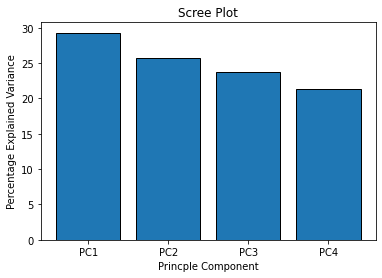

In [5]:
scaled_data = preprocessing.scale(main_df)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# Viusalize scree plot
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels, edgecolor='black')
plt.xlabel("Princple Component")
plt.ylabel("Percentage Explained Variance")
plt.title("Scree Plot")
# plt.savefig('Results/Scree Plot.png', bbox_inches='tight')
plt.show()

Print out the PCA Graph by using the 2 most significant PCA's

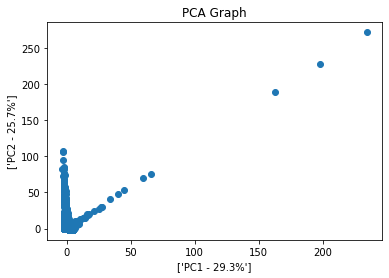

In [6]:
pca_df = pd.DataFrame(pca_data, index=pca_data.T[0], columns=labels)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('PCA Graph')
plt.xlabel(['PC1 - {0}%'.format(per_var[0])])
plt.ylabel(['PC2 - {0}%'.format(per_var[1])])

df1 = pca_df[['PC1', 'PC2']]
# plt.savefig('Results/pca_graph.png', bbox_inches='tight')
plt.show()

### Analysis
- Using the information from the scree plot and the plotted PCA Graph of the two most significant PCA’s, the percentage of variation explained by PC1 and PC2 was 24.1% and 20.6% respectively. 
- Looking at the data above it is clear that PC1 and PC2 are not sufficient enough to explain most of the variance in the data. 
- This highlights that dimensionality reduction on this dataset of 5 features is not viable as there is no one dominating PCA. 
- Also, reducing the number of features is not possible

### Classification
(1) Decision Tree Classifier


In [7]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [11]:
df_filtered = pd.read_csv('Results/ModelData.csv', low_memory=False)
df_sample = df_filtered.sample(100000)

Use a sample of 100,000 objects and calculate mahalanobis distance.

In [12]:
# Mahalanobis Distance
from scipy.spatial.distance import cdist
import numpy as np

# Find the mean for each attribute
df_mahalonobis = df_sample

data_mahala = df_mahalonobis.to_numpy().astype(float)
mean = np.mean(data_mahala, axis=0)

def calculateMahalanobis(x, mean, data):
    diff_data_mean = x - mean

    data_mahala = np.transpose(data)
    covM = np.cov(data_mahala, bias=False)
    invCovM = np.linalg.inv(covM)

    tem1 = np.dot(diff_data_mean, invCovM)
    tem2 = np.dot(tem1, np.transpose(diff_data_mean))

    m_distance = np.sqrt(tem2)

    return m_distance

mahala_distances = []

for x in data_mahala:
    distance = calculateMahalanobis(x, mean, data_mahala)
    mahala_distances.append(round(distance,3))
    # print(np.reshape(distance,-1))

print(mahala_distances[:100])

[1.583, 1.128, 1.541, 2.091, 1.152, 0.999, 3.174, 1.409, 0.968, 0.288, 0.877, 0.994, 1.25, 1.633, 1.084, 0.579, 1.717, 0.6, 1.132, 1.515, 0.244, 1.441, 1.301, 0.839, 0.801, 1.253, 0.976, 1.549, 0.678, 1.536, 0.664, 1.051, 0.707, 0.95, 1.072, 1.678, 3.54, 1.901, 0.759, 1.192, 1.444, 1.761, 2.57, 0.992, 1.015, 0.957, 1.058, 1.13, 1.944, 0.996, 1.89, 1.317, 3.059, 0.928, 1.198, 1.243, 3.821, 1.46, 1.037, 2.034, 2.42, 0.797, 1.399, 2.251, 1.464, 1.411, 0.287, 0.874, 1.076, 0.518, 1.139, 0.962, 1.605, 1.158, 1.394, 1.059, 1.085, 2.001, 1.041, 3.502, 1.818, 1.339, 0.877, 0.969, 1.485, 1.491, 1.02, 1.823, 1.043, 0.989, 1.84, 1.157, 0.996, 0.98, 1.324, 1.081, 0.74, 1.096, 1.695, 4.895]


Visualize the distances to see if there is any patterns. Try to split into 3 distinct classes

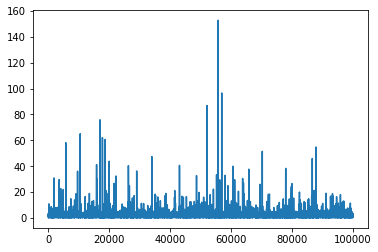

In [35]:
plt.plot(mahala_distances)
plt.show()

In [37]:
# std = statistics.pstdev(euclidean_distances)
# mean_distance = statistics.mean(euclidean_distances)
labels = []
m = max(mahala_distances)

for distance in mahala_distances:
    if 0 <= distance <= 1:
        labels.append(1)
    elif 1 < distance <= 1.5 :
        labels.append(2)
    else:
        labels.append(3)

print(len(labels))

100000


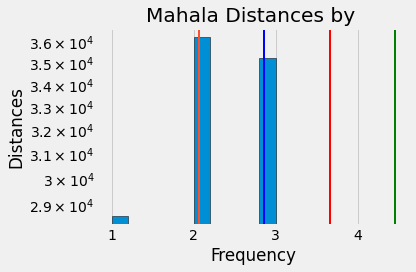

In [38]:
# Mahalonobis
import pandas as pd
from matplotlib import pyplot as plt
import statistics

plt.style.use('fivethirtyeight')

# the log parameter shows the the data in a semi-log scale to see frequency of groups with smaller counts
plt.hist(labels,  edgecolor='black', log=True)

median_distance = statistics.mean(labels)
color = '#fc4f30'

std = statistics.pstdev(labels)

# Adds a median line allowing us to see infer information about the data
plt.axvline(median_distance, color=color, label=f'Median Distance {round(median_distance,2)}', linewidth=2)
plt.axvline(median_distance + std, color='blue', label=f'Standard Deviation {round(median_distance + std,2)}', linewidth=2)
plt.axvline(median_distance + 2*std, color='red', label=f'Standard Deviation {round(median_distance + 2*std,2)}', linewidth=2)
plt.axvline(median_distance + 3*std, color='green', label=f'Standard Deviation {round(median_distance + 3*std,2)}', linewidth=2)

# plt.legend()
plt.title('Mahala Distances by ')
plt.xlabel('Frequency')
plt.ylabel('Distances')

plt.tight_layout()

plt.show()

Split the distances into 3 class intervals. 0-1 as class one, 1-1.5 as class two and 1.5+ is class 3.

Using the Decision Tree Classifier, make a 70-30 split. 70% training and 30% test. 
This split resulted in the highest performance of the model and in turn the accuracy. On
average there was an accuracy of 98%. A visualization of the Decision Tree is as shown below

In [49]:
x = df_sample # Features
y = pd.DataFrame(labels) # class labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

# Create Decision Tree classifier
clf = DecisionTreeClassifier()

# Train DTC
clf = clf.fit(x_train, y_train)

# predict the response for the train dataset
# y_pred = clf.predict(x_train)
# print(f"Train Accuracy: {metrics.accuracy_score(y_train, y_pred)}")

# predict the response for the test dataset
y_pred = clf.predict(x_test)
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9783666666666667


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.243237 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.243237 to fit



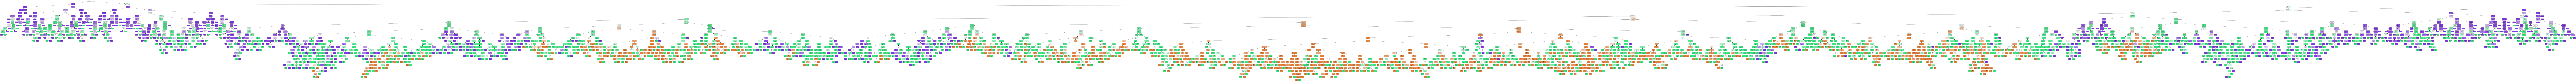

In [51]:
from six import StringIO
from sklearn import tree
from IPython.display import Image  
import pydotplus

feature_cols = ['averageRating', 'numVotes', 'startYear', 'runtimeMinutes']
data = tree.export_graphviz(clf, out_file=None,  
                filled=True, rounded=True, feature_names = feature_cols,class_names=['1','2', '3'])

graph = pydotplus.graph_from_dot_data(data) 
graph.write_png('DecisionTree.png')
Image(graph.create_png())